In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from pyod.models.suod import SUOD, LOF, COPOD, IForest, HBOS
from autogluon.features.generators import AutoMLPipelineFeatureGenerator
from scipy.stats import chi2_contingency
from sklearn import metrics
from autogluon.tabular import TabularPredictor
import plotnine as p9
import pandas as pd
from helpers import load_adult_data, sim_cov_shift
import numpy as np
import os, urllib

In [6]:

np.load('https://github.com/Minqi824/ADBench/raw/main/datasets/Classical/11_donors.npz', allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'https://github.com/Minqi824/ADBench/raw/main/datasets/Classical/11_donors.npz'

In [79]:
train, test = load_adult_data()
train_cs, test_cs = sim_cov_shift(train, test)

In [80]:
train_cs.shape

(29983, 15)

In [81]:
feature_generator = AutoMLPipelineFeatureGenerator()
train_trans = feature_generator.fit_transform(X=train_cs)
test_trans = feature_generator.transform(test_cs)

In [8]:
help(AutoMLPipelineFeatureGenerator)

Help on class AutoMLPipelineFeatureGenerator in module autogluon.features.generators.auto_ml_pipeline:

class AutoMLPipelineFeatureGenerator(autogluon.features.generators.pipeline.PipelineFeatureGenerator)
 |  AutoMLPipelineFeatureGenerator(enable_numeric_features=True, enable_categorical_features=True, enable_datetime_features=True, enable_text_special_features=True, enable_text_ngram_features=True, enable_raw_text_features=False, enable_vision_features=True, vectorizer=None, text_ngram_params=None, **kwargs)
 |  
 |  Pipeline feature generator with simplified arguments to handle most Tabular data including text and dates adequately.
 |  This is the default feature generation pipeline used by AutoGluon when unspecified.
 |  For more customization options, refer to :class:`PipelineFeatureGenerator` and :class:`BulkFeatureGenerator`.
 |  
 |  Parameters
 |  ----------
 |  enable_numeric_features : bool, default True
 |      Whether to keep features of 'int' and 'float' raw types.
 |    

In [82]:
# initialized a group of outlier detectors for acceleration
#detector_list = [LOF(n_neighbors=15), LOF(n_neighbors=20),
#                 LOF(n_neighbors=25), LOF(n_neighbors=35),
#                 COPOD(), IForest(n_estimators=100),
#                 IForest(n_estimators=200)]

# decide the number of parallel process, and the combination method
# then clf can be used as any outlier detection model
clf = IForest()

In [83]:
clf.fit(train_trans)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [39]:
train_ano_scores = clf.decision_function(train_trans)

test_ano_scores = clf.decision_function(test_trans)

In [41]:
test_cs['ano_scores'] = test_ano_scores
test_cs['dataset'] = 'test'
train_cs['ano_scores'] = train_ano_scores
train_cs['dataset'] = 'train'

In [44]:
full_ano_data = pd.concat( (train_cs, test_cs) )

In [54]:
full_ano_data.columns = full_ano_data.columns.str.replace('-', '_')

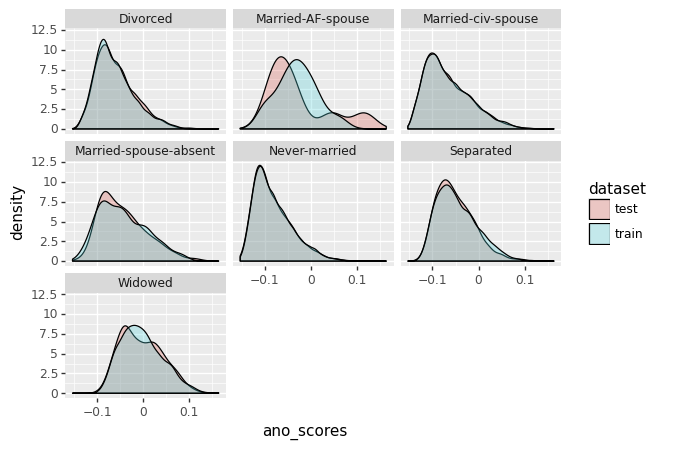

<ggplot: (8772251407794)>

In [55]:
p9.ggplot(full_ano_data, p9.aes(x = 'ano_scores', fill = 'dataset'))\
+ p9.geom_density(alpha = 0.3) + p9.facet_wrap('~ marital_status')

In [89]:
ano_pivot = full_ano_data.value_counts(['dataset', 'marital_status']).reset_index().pivot('marital_status','dataset')

In [91]:
ano_cross = pd.crosstab(full_ano_data['dataset'], full_ano_data['marital_status'])

chi2_contingency(ano_cross)

In [76]:
ano_pivot / ano_pivot.sum(axis=0)

0          
dataset                    test     train
marital_status                           
Divorced               0.087661  0.166321
Married-AF-spouse      0.000422  0.000970
Married-civ-spouse     0.646242  0.338998
Married-spouse-absent  0.008866  0.015388
Never-married          0.214957  0.402890
Separated              0.019897  0.038570
Widowed                0.021955  0.036864

In [84]:
train_ano_scores = clf.predict(train_trans)
test_ano_scores = clf.predict(test_trans)

In [87]:
train_ano_scores.mean()

0.1000233465630524

In [88]:
test_ano_scores.mean()

0.10578503632218039

In [41]:
test_cs['ano_scores'] = test_ano_scores
test_cs['dataset'] = 'test'
train_cs['ano_scores'] = train_ano_scores
train_cs['dataset'] = 'train'